In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import interpolate
from sklearn.utils import shuffle

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from tensorflow.python.client import device_lib
physical_gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

2024-10-27 12:11:55.757915: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-10-27 12:11:57.230159: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:3b:00.0
2024-10-27 12:11:57.230379: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-10-27 12:11:57.231782: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2024-10-27 12:11:57.232979: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2024-10-27 12:11:57.233259: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2024-10-27 12:11:57.234780: I tensorflow/stream_executor/platform/d

In [313]:
# Setting up training and testing data:
mean_1 = [0, 0, 0, 0, 0]
cov_1 = [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1,0], [0, 0, 0, 0, 1]]

mean_2 = [1, 1, 1, 1, 1]
cov_2 = [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1,0], [0, 0, 0, 0, 1]]

mean_3 = [-1, -1, -1, -1, -1]
cov_3 = [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1,0], [0, 0, 0, 0, 1]]


x_1 = np.random.multivariate_normal(mean_1, cov_1, size=1000000)
y_1 = np.random.multivariate_normal(mean_1, cov_1, size=100000)

x_2 = np.random.multivariate_normal(mean_2, cov_2, size=1000000)
y_2 = np.random.multivariate_normal(mean_2, cov_2, size=100000)

x_3 = np.random.multivariate_normal(mean_3, cov_3, size=1000000)
y_3 = np.random.multivariate_normal(mean_3, cov_3, size=100000)


In [314]:
print(x_1[0])

[-0.11382951  1.06740783 -0.00189439 -0.09878673 -1.23415305]


Distribution of the raw samples

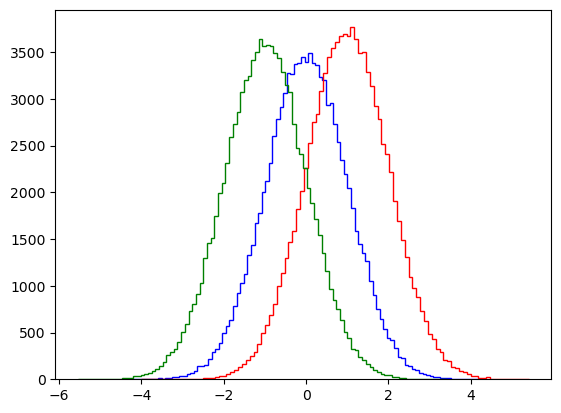

In [333]:
plt.hist(y_1[:,0], bins = 100, edgecolor = 'b', histtype = 'step')
plt.hist(y_2[:,0], bins = 100, edgecolor = 'r', histtype = 'step')
plt.hist(y_3[:,0], bins = 100, edgecolor = 'g', histtype = 'step')
plt.show()

In [334]:
# Preparing three samples
n_samples = 3
n_1_1 = 80000 #Number of signal samples in dominant class
n_1_2 = 10000
n_1_3 = 10000

n_2_1 = 75000
n_2_2 = 15000
n_2_3 = 10000

n_3_1 = 55000
n_3_2 = 20000
n_3_3 = 25000

sample_1_1_train = x_1[0:n_1_1]
#Using one-hot encoding here
true_label_sample_1_1_train = np.tile(np.array([1., 0., 0.]), 
                                      np.shape(sample_1_1_train)[0]).reshape(np.shape(sample_1_1_train)[0],n_samples)

sample_1_2_train = x_2[0:n_1_2]
true_label_sample_1_2_train = np.tile(np.array([0., 1., 0.]), 
                                      np.shape(sample_1_2_train)[0]).reshape(np.shape(sample_1_2_train)[0],n_samples)
sample_1_3_train = x_3[0:n_1_3]
true_label_sample_1_3_train = np.tile(np.array([0., 0., 1.]), 
                                      np.shape(sample_1_3_train)[0]).reshape(np.shape(sample_1_3_train)[0],n_samples)

sample_2_1_train = x_1[n_1_1:n_1_1+n_2_1]
#Using one-hot encoding here
true_label_sample_2_1_train = np.tile(np.array([1., 0., 0.]), 
                                      np.shape(sample_2_1_train)[0]).reshape(np.shape(sample_2_1_train)[0],n_samples)

sample_2_2_train = x_2[n_1_2:n_1_2 + n_2_2]
true_label_sample_2_2_train = np.tile(np.array([0., 1., 0.]), 
                                      np.shape(sample_2_2_train)[0]).reshape(np.shape(sample_2_2_train)[0],n_samples)
sample_2_3_train = x_3[n_1_3:n_1_3+n_2_3]
true_label_sample_2_3_train = np.tile(np.array([0., 0., 1.]), 
                                      np.shape(sample_2_3_train)[0]).reshape(np.shape(sample_2_3_train)[0],n_samples)

sample_3_1_train = x_1[n_1_1+n_2_1:n_1_1+n_2_1+n_3_1]
#Using one-hot encoding here
true_label_sample_3_1_train = np.tile(np.array([1., 0., 0.]), 
                                      np.shape(sample_3_1_train)[0]).reshape(np.shape(sample_3_1_train)[0],n_samples)

sample_3_2_train = x_2[n_1_2+n_2_2:n_1_2+n_2_2+n_3_2]
true_label_sample_3_2_train = np.tile(np.array([0., 1., 0.]), 
                                      np.shape(sample_3_2_train)[0]).reshape(np.shape(sample_3_2_train)[0],n_samples)
sample_3_3_train = x_3[n_1_3+n_2_3:n_1_3+n_2_3+n_3_3]
true_label_sample_3_3_train = np.tile(np.array([0., 0., 1.]), 
                                      np.shape(sample_3_3_train)[0]).reshape(np.shape(sample_3_3_train)[0],n_samples)






In [335]:
x_test = np.concatenate((y_1, y_2, y_3))
y_test_1 = np.tile(np.array([1., 0., 0.]), 
            np.shape(y_1)[0]).reshape(np.shape(y_1)[0],n_samples)
y_test_2 = np.tile(np.array([0., 1., 0.]), 
            np.shape(y_2)[0]).reshape(np.shape(y_2)[0],n_samples)
y_test_3 = np.tile(np.array([0., 0., 1.]), 
            np.shape(y_3)[0]).reshape(np.shape(y_3)[0],n_samples)
y_test = np.concatenate((y_test_1, y_test_2, y_test_3))

In [238]:
#y_test = np.argmax(y_test, axis = 1)

In [336]:
print(y_test)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


One versus all

In [337]:
rng = np.random.default_rng()
x_train_1 = np.concatenate((sample_1_1_train, sample_1_2_train, sample_1_3_train))
y_train_1 = np.tile(np.array([1., 0., 0.]), 
            np.shape(x_train_1)[0]).reshape(np.shape(x_train_1)[0],n_samples)
true_label_1 = np.concatenate((true_label_sample_1_1_train, true_label_sample_1_2_train, 
                               true_label_sample_1_3_train))
indices_1 = rng.permutation(np.shape(x_train_1)[0])

x_shuffle_1 = x_train_1[indices_1]
y_shuffle_1 = y_train_1[indices_1]
true_label_shuffle_1 = true_label_1[indices_1]

x_train_2 = np.concatenate((sample_2_1_train, sample_2_2_train, sample_2_3_train))
y_train_2 = np.tile(np.array([0., 1., 0.]), 
            np.shape(x_train_2)[0]).reshape(np.shape(x_train_2)[0],n_samples)
true_label_2 = np.concatenate((true_label_sample_2_1_train, true_label_sample_2_2_train, 
                               true_label_sample_2_3_train))
indices_2 = rng.permutation(np.shape(x_train_2)[0])

x_shuffle_2 = x_train_2[indices_2]
y_shuffle_2 = y_train_2[indices_2]
true_label_shuffle_2 = true_label_2[indices_2]

x_train_3 = np.concatenate((sample_3_1_train, sample_3_2_train, sample_3_3_train))
y_train_3 = np.tile(np.array([0., 0., 1.]), 
            np.shape(x_train_3)[0]).reshape(np.shape(x_train_3)[0],n_samples)
true_label_3 = np.concatenate((true_label_sample_3_1_train, true_label_sample_3_2_train, 
                               true_label_sample_3_3_train))
indices_3 = rng.permutation(np.shape(x_train_3)[0])

x_shuffle_3 = x_train_3[indices_3]
y_shuffle_3 = y_train_3[indices_3]
true_label_shuffle_3 = true_label_3[indices_3]


Distribution of the mixed samples

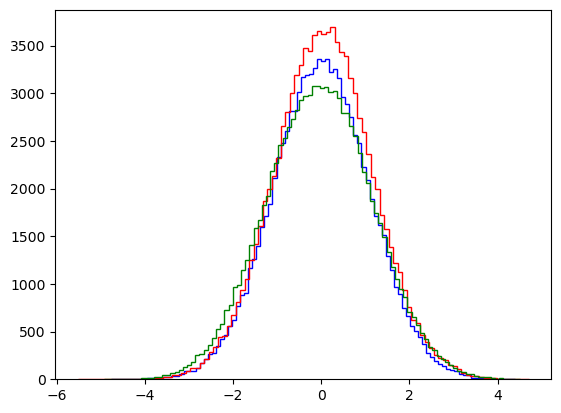

In [338]:
plt.hist(x_train_1[:,0], bins = 100, edgecolor = 'b', histtype = 'step')
plt.hist(x_train_2[:,0], bins = 100, edgecolor = 'r', histtype = 'step')
plt.hist(x_train_3[:,0], bins = 100, edgecolor = 'g', histtype = 'step')
plt.show()

Code from Feng-Yang:

In [339]:
def build_model(input_dim):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(32, input_dim=input_dim, activation='relu'))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(3, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

In [340]:
x_train = np.concatenate((x_shuffle_1, x_shuffle_2, x_shuffle_3))
y_train = np.concatenate((y_shuffle_1, y_shuffle_2, y_shuffle_3))
true_label_train = np.concatenate((true_label_shuffle_1, true_label_shuffle_2, true_label_shuffle_3))

#y_train = np.argmax(y_train, axis = 1)
#true_label_train = np.argmax(true_label_train, axis = 1)

indices_train = rng.permutation(np.shape(x_train)[0])

x_train = x_train[indices_train]
y_train = y_train[indices_train]
true_label_train = true_label_train[indices_train]


In [341]:
print(y_train)

[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


Train on 240000 samples, validate on 60000 samples
Epoch 1/50
240000/240000 [==============================] - 1s 5us/sample - loss: 1.0878 - accuracy: 0.3812 - val_loss: 1.0859 - val_accuracy: 0.3813
Epoch 2/50
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0853 - accuracy: 0.3853 - val_loss: 1.0858 - val_accuracy: 0.3828
Epoch 3/50
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0850 - accuracy: 0.3859 - val_loss: 1.0858 - val_accuracy: 0.3832
Epoch 4/50
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0850 - accuracy: 0.3859 - val_loss: 1.0857 - val_accuracy: 0.3825
Epoch 5/50
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0849 - accuracy: 0.3865 - val_loss: 1.0856 - val_accuracy: 0.3834
Epoch 6/50
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0849 - accuracy: 0.3854 - val_loss: 1.0861 - val_accuracy: 0.3814
Epoch 7/50
240000/240000 [=======================

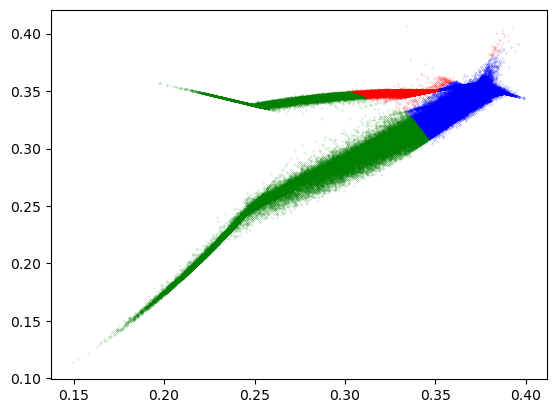

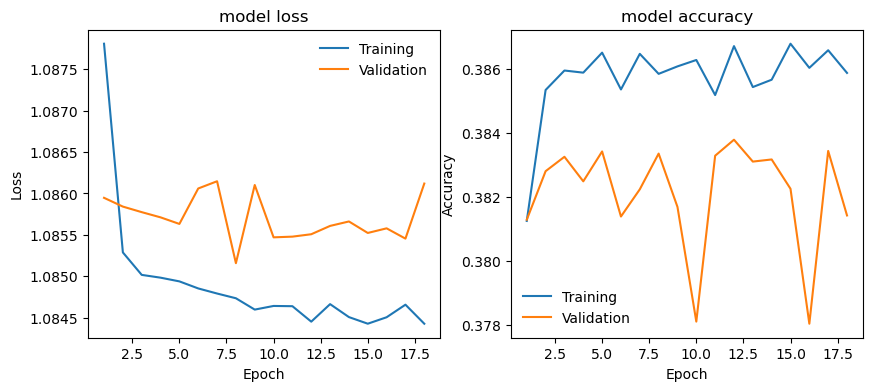

In [366]:
model = build_model(x_train.shape[1])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, patience=10)
y_train_1 = y_train
for i in range(1):
    history = model.fit(x_train, y_train_1, validation_split = 0.2, epochs=50, batch_size=1024, verbose=1, 
                    callbacks=[
                              early_stopping,
                               ])
    predict = model.predict(x_train)
    '''
    predict[np.argmax(predict, axis = 1) == 0] = [1., 0., 0.]
    predict[np.argmax(predict, axis = 1) == 1] = [0., 1., 0.]
    predict[np.argmax(predict, axis = 1) == 2] = [0., 0., 1.]
    '''
    y_train_1 = predict
    predict_0 = predict[np.argmax(y_train_1, axis = 1) == 0]
    predict_1 = predict[np.argmax(y_train_1, axis = 1) == 1]
    predict_2 = predict[np.argmax(y_train_1, axis = 1) == 2]
    plt.scatter(predict_0[:,0], predict_0[:,1], c = 'b', s = 0.01)
    plt.scatter(predict_1[:,0], predict_1[:,1], c = 'r', s = 0.01)
    plt.scatter(predict_2[:,0], predict_2[:,1], c = 'g', s = 0.01)

    plt.show()
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    x = range(1, len(history.history['loss']) + 1)

    ax[0].plot(x, history.history['loss'], label='Training')
    ax[0].plot(x, history.history['val_loss'], label='Validation')

    ax[0].legend(frameon=False)
    ax[0].set_title(f'model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(x, history.history['accuracy'], label='Training')
    ax[1].plot(x, history.history['val_accuracy'], label='Validation')

    ax[1].legend(frameon=False)
    ax[1].set_title(f'model accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    plt.show()

In [343]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"One-vs-All Test Accuracy: {accuracy * 100:.2f}%")

One-vs-All Test Accuracy: 61.25%


In [358]:
loss, accuracy = model.evaluate(x_train[-100000:], y_train[-100000:], verbose=0)
print(f"One-vs-All Test Accuracy: {accuracy * 100:.2f}%")

One-vs-All Test Accuracy: 38.45%


In [344]:
x_predict = model.predict(x_test)

In [362]:
y_predict = model.predict(x_train[-100000:])

In [345]:
print(x_predict)

[[0.38456672 0.35367456 0.26175871]
 [0.38456672 0.35367456 0.26175871]
 [0.38456672 0.35367456 0.26175871]
 ...
 [0.34383458 0.32808873 0.3280767 ]
 [0.29576442 0.27704707 0.42718852]
 [0.2500587  0.22290696 0.52703434]]


In [346]:
print(np.max(x_predict))

0.63208514


In [347]:
print(np.shape(x_predict_1))

(100000, 3)


In [348]:
print(x_predict_2)

[[0.25416815 0.26361603 0.48221582]
 [0.26797926 0.27343783 0.45858288]
 [0.33948323 0.3185249  0.3419918 ]
 ...
 [0.32394537 0.30957952 0.36647508]
 [0.30065385 0.2952663  0.40407988]
 [0.22830367 0.24428795 0.52740836]]


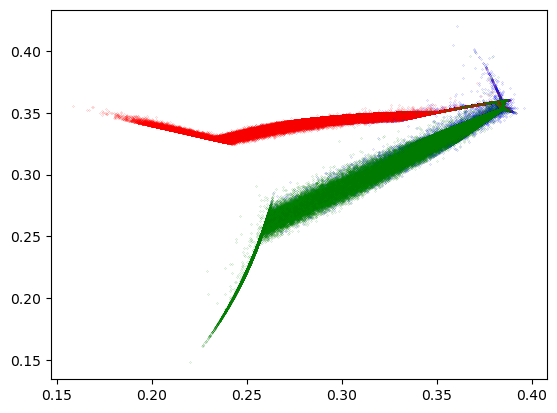

In [361]:
x_predict_0 = x_predict[np.argmax(y_test, axis = 1) == 0]
x_predict_1 = x_predict[np.argmax(y_test, axis = 1) == 1]
x_predict_2 = x_predict[np.argmax(y_test, axis = 1) == 2]
plt.scatter(x_predict_0[:,0], x_predict_0[:,1], c = 'b', s = 0.01)
plt.scatter(x_predict_1[:,0], x_predict_1[:,1], c = 'r', s = 0.01)
plt.scatter(x_predict_2[:,0], x_predict_2[:,1], c = 'g', s = 0.01)

plt.show()

In [331]:
print(np.shape(np.argmax(x_predict_0, axis = 1)[np.argmax(x_predict_0, axis = 1) == 0]))
print(np.shape(np.argmax(x_predict_1, axis = 1)[np.argmax(x_predict_1, axis = 1) == 1]))
print(np.shape(np.argmax(x_predict_2, axis = 1)[np.argmax(x_predict_2, axis = 1) == 2]))


(63079,)
(91649,)
(88578,)


In [332]:
loss, accuracy = model.evaluate(y_3, y_test_3, verbose=0)
print(f"One-vs-All Test Accuracy: {accuracy * 100:.2f}%")

One-vs-All Test Accuracy: 88.58%


In [301]:
print(np.argmax(x_predict_0, axis = 1) == 1)

[False False False ... False False False]


In [50]:
print(np.mean(x_predict_0), np.mean(x_predict_1), np.mean(x_predict_2))

0.33333337 0.33333337 0.33333334


One versus Rest strategy

In [350]:
def build_model_ovr(input_dim):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(16, input_dim=input_dim, activation='relu'))
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

Train on 240000 samples, validate on 60000 samples
Epoch 1/50
240000/240000 [==============================] - 1s 6us/sample - loss: 0.6332 - accuracy: 0.6648 - val_loss: 0.6322 - val_accuracy: 0.6666
Epoch 2/50
240000/240000 [==============================] - 1s 4us/sample - loss: 0.6314 - accuracy: 0.6667 - val_loss: 0.6320 - val_accuracy: 0.6666
Epoch 3/50
240000/240000 [==============================] - 1s 5us/sample - loss: 0.6313 - accuracy: 0.6667 - val_loss: 0.6321 - val_accuracy: 0.6666
Epoch 4/50
240000/240000 [==============================] - 1s 5us/sample - loss: 0.6312 - accuracy: 0.6667 - val_loss: 0.6320 - val_accuracy: 0.6666
Epoch 5/50
240000/240000 [==============================] - 1s 5us/sample - loss: 0.6313 - accuracy: 0.6667 - val_loss: 0.6319 - val_accuracy: 0.6666
Epoch 6/50
240000/240000 [==============================] - 1s 5us/sample - loss: 0.6311 - accuracy: 0.6667 - val_loss: 0.6326 - val_accuracy: 0.6666
Epoch 7/50
240000/240000 [=======================

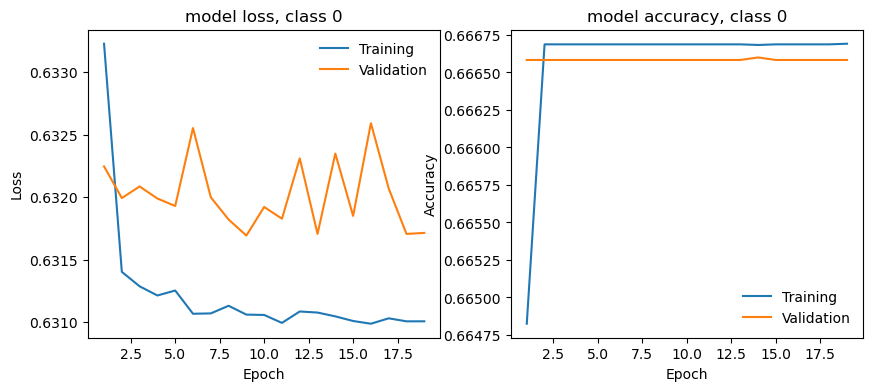

Train on 240000 samples, validate on 60000 samples
Epoch 1/50
240000/240000 [==============================] - 1s 6us/sample - loss: 0.6357 - accuracy: 0.6659 - val_loss: 0.6355 - val_accuracy: 0.6653
Epoch 2/50
240000/240000 [==============================] - 1s 4us/sample - loss: 0.6340 - accuracy: 0.6670 - val_loss: 0.6350 - val_accuracy: 0.6653
Epoch 3/50
240000/240000 [==============================] - 1s 4us/sample - loss: 0.6337 - accuracy: 0.6670 - val_loss: 0.6354 - val_accuracy: 0.6653
Epoch 4/50
240000/240000 [==============================] - 1s 5us/sample - loss: 0.6337 - accuracy: 0.6670 - val_loss: 0.6349 - val_accuracy: 0.6653
Epoch 5/50
240000/240000 [==============================] - 1s 5us/sample - loss: 0.6338 - accuracy: 0.6670 - val_loss: 0.6358 - val_accuracy: 0.6653
Epoch 6/50
240000/240000 [==============================] - 1s 5us/sample - loss: 0.6338 - accuracy: 0.6670 - val_loss: 0.6351 - val_accuracy: 0.6653
Epoch 7/50
240000/240000 [=======================

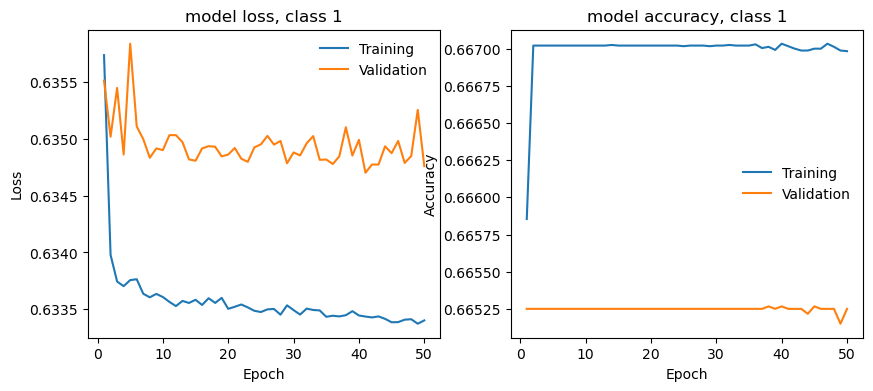

Train on 240000 samples, validate on 60000 samples
Epoch 1/50
240000/240000 [==============================] - 1s 6us/sample - loss: 0.6280 - accuracy: 0.6684 - val_loss: 0.6231 - val_accuracy: 0.6709
Epoch 2/50
240000/240000 [==============================] - 1s 4us/sample - loss: 0.6239 - accuracy: 0.6703 - val_loss: 0.6230 - val_accuracy: 0.6704
Epoch 3/50
240000/240000 [==============================] - 1s 5us/sample - loss: 0.6237 - accuracy: 0.6699 - val_loss: 0.6227 - val_accuracy: 0.6711
Epoch 4/50
240000/240000 [==============================] - 1s 5us/sample - loss: 0.6236 - accuracy: 0.6701 - val_loss: 0.6228 - val_accuracy: 0.6711
Epoch 5/50
240000/240000 [==============================] - 1s 5us/sample - loss: 0.6235 - accuracy: 0.6700 - val_loss: 0.6227 - val_accuracy: 0.6715
Epoch 6/50
240000/240000 [==============================] - 1s 4us/sample - loss: 0.6234 - accuracy: 0.6704 - val_loss: 0.6226 - val_accuracy: 0.6709
Epoch 7/50
240000/240000 [=======================

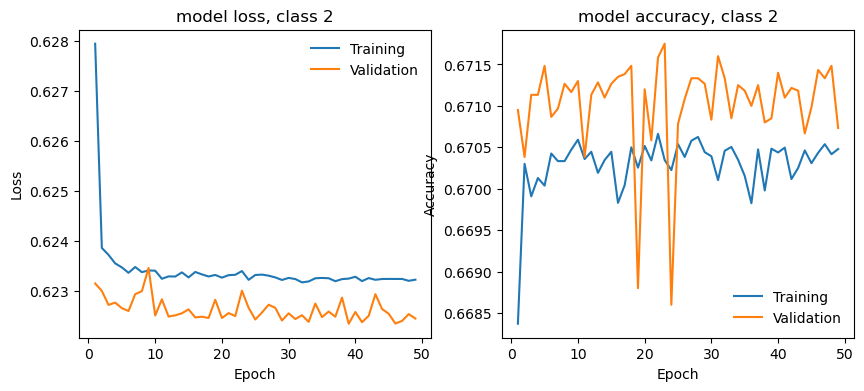

In [352]:
models = []
for class_index in range(n_samples):
    y_train_bin = np.where(np.argmax(y_train, axis = 1) == class_index, 1, 0)
    model_2 = build_model_ovr(x_train.shape[1])
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, patience=10)
    history_2 = model_2.fit(x_train, y_train_bin, validation_split = 0.2, epochs=50, batch_size=1024, verbose=1, 
                    callbacks=[
                              early_stopping,
                               ])
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    x = range(1, len(history_2.history['loss']) + 1)

    ax[0].plot(x, history_2.history['loss'], label='Training')
    ax[0].plot(x, history_2.history['val_loss'], label='Validation')

    ax[0].legend(frameon=False)
    ax[0].set_title(f'model loss, class {class_index}')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(x, history_2.history['accuracy'], label='Training')
    ax[1].plot(x, history_2.history['val_accuracy'], label='Validation')

    ax[1].legend(frameon=False)
    ax[1].set_title(f'model accuracy, class {class_index}')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    plt.show()
    
    models.append(model_2)

In [356]:
# Making predictions using the OvR strategy
def predict_ovr(models, X_test):
    predictions = np.zeros((X_test.shape[0], len(models)))
    
    # Predict using each model
    for idx, model in enumerate(models):
        pred = model.predict(X_test)
        predictions[:, idx] = pred.flatten()
    
    # The final class is the one with the highest confidence score
    return np.argmax(predictions, axis=1), predictions

# Get final predictions
final_predictions, predictions = predict_ovr(models, x_test)

# Calculate accuracy
accuracy = np.mean(final_predictions == np.argmax(y_test, axis = 1))
print(f"One-vs-Rest Test Accuracy: {accuracy * 100:.2f}%")
print(final_predictions)

One-vs-Rest Test Accuracy: 56.88%
[0 0 0 ... 0 2 2]


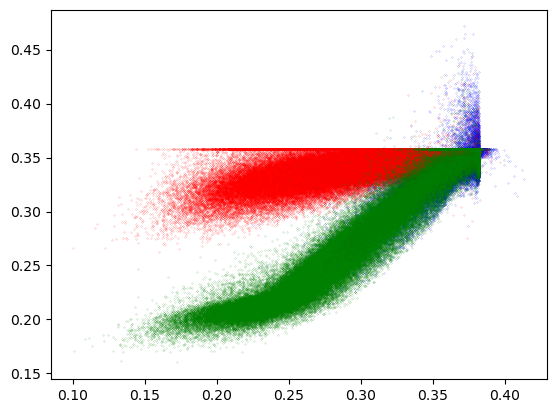

In [357]:
y_predict_0 = predictions[np.argmax(y_test, axis = 1) == 0]
y_predict_1 = predictions[np.argmax(y_test, axis = 1) == 1]
y_predict_2 = predictions[np.argmax(y_test, axis = 1) == 2]
plt.scatter(y_predict_0[:,0], y_predict_0[:,1], c = 'b', s = 0.01)
plt.scatter(y_predict_1[:,0], y_predict_1[:,1], c = 'r', s = 0.01)
plt.scatter(y_predict_2[:,0], y_predict_2[:,1], c = 'g', s = 0.01)

plt.show()